In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_gpu = torch.cuda.is_available()
print(torch.__version__)
print(device)

2.0.0
cuda:0


# Initialize for CPU & GPU

In [2]:
if use_gpu:
    !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --no-index --find-links=file:///kaggle/input/torch-geometric
#     !pip install torch_geometric_temporal  
else:
    !pip install /kaggle/input/pytorch-geometric-cpu/torch_scatter-2.1.1pt20cpu-cp310-cp310-linux_x86_64.whl
    !pip install /kaggle/input/pytorch-geometric-cpu/torch_sparse-0.6.17pt20cpu-cp310-cp310-linux_x86_64.whl
    !pip install /kaggle/input/pytorch-geometric-cpu/torch_cluster-1.6.1pt20cpu-cp310-cp310-linux_x86_64.whl
    !pip install /kaggle/input/pytorch-geometric-cpu/torch_spline_conv-1.2.2pt20cpu-cp310-cp310-linux_x86_64.whl
    !pip install /kaggle/input/pytorch-geometric-cpu/torch_geometric-2.3.1-py3-none-any.whl
#     !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
#     !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
#     !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
#     !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
#     !pip install torch_spline_conv -f https://data.pyg.org/whl/torch-{torch.__version__}.html
#     !pip install git+https://github.com/pyg-team/pytorch_geometric.git
#     !pip install torch_geometric_temporal

Looking in links: file:///kaggle/input/torch-geometric
Processing /kaggle/input/torch-geometric/torch_scatter-2.1.1-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_sparse-0.6.17-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_cluster-1.6.1-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_spline_conv-1.2.2-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/torch-geometric/torch_geometric-2.3.1-py3-none-any.whl


# Import

In [3]:
import numpy as np
import pandas as pd
import os
import re
import json
import random
from scipy.special import perm
from itertools import combinations,chain
from typing import List, Union
from torch_geometric.data import Data
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import pickle
import time
from torch import nn
from torch.nn import Linear as Lin
from torch.nn import ReLU, LeakyReLU
from torch.nn import Sequential as Seq
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.data import Batch
from torch import autograd
from torch_geometric.nn.models import InnerProductDecoder
from torch_geometric.utils import to_dense_adj

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

from texttable import Texttable

# DataLoader

In [4]:
Edge_Flag = List[Union[np.ndarray, None]]
Edge_Index = List[Union[np.ndarray, None]]
Edge_Attr = List[Union[np.ndarray, None]]

Node_Flag = List[Union[np.ndarray, None]]
Node_Index = List[Union[np.ndarray, None]]
Node_Attr = List[Union[np.ndarray, None]]



class GraphSignal(object):
    # dynamic node static node attr dynamic edge and edge attr
    def __init__(
        self,
        edge_flag: Edge_Flag,
        edge_index: Edge_Index,
        edge_attr: Edge_Attr,
        node_flag: Node_Flag,
        node_index: Node_Index,
        node_attr: Node_Attr,
        ts_list: List,
        path: str,
    ):
        
        self.raw_edge_flag = torch.LongTensor(edge_flag[:-1])
        self.raw_edge_index = torch.LongTensor(edge_index).T
        self.raw_edge_attr = edge_attr
        self.raw_node_attr = node_attr 
        self.node_flag = torch.LongTensor(node_flag[:-1])
        self.node_index = torch.LongTensor(node_index)
        
        self.ts_list = ts_list
        
        self.path = path
        
        self.node_attr = None
        self.edge_flag = None
        self.edge_index = None
        
        self.y = None
        
        self._set_snapshot_count()
        self._set_node_count()

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.ts_list)
    
    def _set_node_count(self):
        self.node_count = self.raw_node_attr.shape[0]
    
    def encode_edge_attr(self, enocder):
        self.edge_attr_encoded = torch.FloatTensor(enocder.transform(self.raw_edge_attr))
        
    def encode_node_attr(self, enocder):
        self.node_attr_encoded = torch.FloatTensor(enocder.transform(self.raw_node_attr))
        
    def extend_node_attr(self):
        if self.edge_attr_encoded is None:
            print("Edge Attr Need to be Encoded!")
            raise
        node_index = self.node_index
        node_attr = self.node_attr_encoded.index_select(dim=0,index=self.node_index)
        node_flag = self.node_flag
        
        edge_index = self.raw_edge_index
        edge_attr = self.edge_attr_encoded
        edge_flag = self.raw_edge_flag
        
        node_index_split = torch.tensor_split(node_index, node_flag)
        node_attr_split = torch.tensor_split(node_attr, node_flag)
        edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
        edge_attr_split = torch.tensor_split(edge_attr, edge_flag)

        base = 0
        new_node_attr = []
        new_edge_flag = []
        new_edge_index = []
        
        for i_snapshot in range(self.snapshot_count):
            _node_index = node_index_split[i_snapshot]
            _node_attr = node_attr_split[i_snapshot]
            _edge_index = edge_index_split[i_snapshot]
            _edge_attr = edge_attr_split[i_snapshot]

            if _edge_index.shape[1] != _edge_attr.shape[0]:
                print(i_snapshot, edge_index.shape, _edge_attr.shape)
                raise
            if _edge_index.shape[1] > 0:
                index_dict = {}
                for i_edge in range(_edge_index.shape[1]):
                    index_tuple = tuple(_edge_index[:,i_edge].tolist())
                    if index_tuple in index_dict:
                        index_dict[index_tuple] += [i_edge]
                    else:
                        index_dict[index_tuple] = [i_edge]

                _new_edge_index = []
                _new_edge_attr = []
                for key in index_dict.keys():
                    _new_edge_index.append(key)
                    _new_edge_attr.append(torch.sum(_edge_attr.index_select(0, torch.LongTensor(index_dict[key])),dim=0).unsqueeze(0))

                _new_edge_index = torch.LongTensor(_new_edge_index).T
                _new_edge_attr = torch.cat(_new_edge_attr,dim=0)
                
                base += _new_edge_index.shape[1]
                new_edge_index.append(_new_edge_index)

#                 _source_attr = torch.zeros((_node_attr.shape[0], _new_edge_attr.shape[1])).to(device)
#                 _target_attr = torch.zeros((_node_attr.shape[0], _new_edge_attr.shape[1])).to(device)
#                 _source_attr.index_add_(0, _new_edge_index[0], _new_edge_attr)
#                 _target_attr.index_add_(0, _new_edge_index[1], _new_edge_attr)
#                 new_node_attr.append(torch.cat([_node_attr,_source_attr,_target_attr], dim=1))

                _node_attr_extend = torch.zeros((_node_attr.shape[0], _new_edge_attr.shape[1]))
                _node_attr_extend.index_add_(0, _new_edge_index[0], _new_edge_attr)
                _node_attr_extend.index_add_(0, _new_edge_index[1], _new_edge_attr)
                new_node_attr.append(torch.cat([_node_attr,_node_attr_extend], dim=1)) 
                
            new_edge_flag.append(base)
        
        self.node_attr = torch.cat(new_node_attr, dim=0)
        self.edge_flag = torch.LongTensor(new_edge_flag)
        self.edge_index = torch.cat(new_edge_index,dim=1)
    
    def remove_init_stop(self, threshold, period):
        node_index = self.node_index
        node_attr = self.node_attr
        node_flag = self.node_flag

        edge_index = self.edge_index
        edge_flag = self.edge_flag
        
        raw_edge_index = self.raw_edge_index
        raw_edge_attr = self.raw_edge_attr
        raw_edge_flag = self.raw_edge_flag

        node_index_split = torch.tensor_split(node_index, node_flag)
        node_attr_split = torch.tensor_split(node_attr, node_flag)
        edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
        
        raw_edge_index_split = torch.tensor_split(raw_edge_index, raw_edge_flag, dim=1)
        raw_edge_attr_split = np.split(raw_edge_attr, raw_edge_flag)

        i_init = None
        i_stop = None
        for i_snapshot, node_num in enumerate(torch.diff(self.node_flag)):
            if node_num > threshold:
                i_init = i_snapshot+1
                break

        for i_snapshot, node_num in enumerate(torch.flip(torch.diff(self.node_flag),dims=[0])):
            if node_num > threshold:
                i_stop = self.node_flag.shape[0]-1-i_snapshot
                break
        
        new_node_attr = torch.cat(node_attr_split[i_init+1+period:i_stop-period],dim=0)
        new_node_index = torch.cat(node_index_split[i_init+1+period:i_stop-period],dim=0)
        new_edge_index = torch.cat(edge_index_split[i_init+1+period:i_stop-period],dim=1)
        new_raw_edge_index = torch.cat(raw_edge_index_split[i_init+1+period:i_stop-period], dim=1)
        new_raw_edge_attr = np.concatenate(raw_edge_attr_split[i_init+1+period:i_stop-period])

        new_node_flag = node_flag[i_init+period+1:i_stop-period-1]-node_flag[i_init+period]
        new_edge_flag = edge_flag[i_init+period+1:i_stop-period-1]-edge_flag[i_init+period]
        new_raw_edge_flag = raw_edge_flag[i_init+period+1:i_stop-period-1]-raw_edge_flag[i_init+period]
        
        self.node_attr = F.tanh(new_node_attr)
        self.node_index = new_node_index
        self.edge_index = new_edge_index
        self.raw_edge_attr = new_raw_edge_attr
        self.raw_edge_index = new_raw_edge_index
        
        self.node_flag = new_node_flag
        self.edge_flag = new_edge_flag
        self.raw_edge_flag = new_raw_edge_flag
        
        self.ts_list = self.ts_list[i_init+1+period:i_stop-period]
        
        self._set_snapshot_count()
    
    def annotation2y(self, annotation, interval, overlap, offset= -30):
        ts_list = self.ts_list
        y = torch.zeros(self.snapshot_count, dtype=torch.long)
        for i_ts, ts in enumerate(ts_list):
            if ts < float(annotation[1])+offset and float(annotation[1])+offset <= ts+interval-overlap: 
                y[i_ts] = 1
        self.y = y
    
    def to(self,device):
        self.node_attr = self.node_attr.to(device)
        self.node_index = self.node_index.to(device)
        self.edge_index = self.edge_index.to(device)
    
    def get_adj_list(self):
        edge_index = self.edge_index
        edge_flag = self.edge_flag
        edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
        adj_list = [torch.clamp(to_dense_adj(_edge_index)[0], min=0, max=1) for _edge_index in edge_index_split]
        return adj_list

    def _get_edge_index(self, time_index: int):
        if time_index == 0:
            _start = 0
        else:
            _start = self.edge_flag[time_index-1]
        _end = self.edge_flag[time_index]
        _edge_index = self.edge_index[:,_start:_end]
        return _edge_index

    def _get_edge_attr(self, time_index: int):
        if self.edge_attr_encoded is None:
            print("Edge Attr Need to be Encoded!")
            raise
        if time_index == 0:
            _start = 0
        else:
            _start = self.edge_flag[time_index-1]
        _end = self.edge_flag[time_index]
        _edge_attr = self.edge_attr_encoded[_start:_end]
        return _edge_attr
    
    def _get_node_index_attr(self, time_index: int):
        if self.node_attr_encoded is None:
            print("Node Attr Need to be Encoded!")
            raise
        if time_index == 0:
            _start = 0
        else:
            _start = self.node_flag[time_index-1]
        _end = self.node_flag[time_index]
        _node_index = self.node_index[_start:_end]
        _node_attr = self.node_attr_encoded[_node_index]
        return _node_index,_node_attr
    
    def _get_timestamp(self, time_index: int):
        _timestamp = self.ts_list[time_index]
        return _timestamp


    def __getitem__(self, time_index: int):
        edge_index = self._get_edge_index(time_index)
        edge_attr = self._get_edge_attr(time_index)
        node_index,node_attr = self._get_node_index_attr(time_index)
        _timestamp = self._get_timestamp(time_index)

        snapshot = Data(
            edge_index=edge_index,
            edge_attr=edge_attr,
            node_index=node_index,
            node_attr=node_attr,
            timestamp=_timestamp
        )
        return snapshot

    def __next__(self):
        if self.t < self.snapshot_count:
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self
    
    def __len__(self):
        return self.snapshot_count


class GraphDatasetLoader(object):
    def __init__(self,input_path=""):
        self.input_path = input_path
        self._read_data()
    
    def _read_data(self):
        self._dataset = np.load(self.input_path)

    def get_dataset(self): # -> DynamicGraphTemporalSignal:
        dataset = GraphSignal(
            edge_flag = self._dataset['edge_flag'],
            edge_index = self._dataset['edge_index'],
            edge_attr = self._dataset['edge_attr'],
            node_flag = self._dataset['node_flag'],
            node_index = self._dataset['node_index'],
            node_attr = self._dataset['node_attr'],
            ts_list = self._dataset['timestamp'],
            path = self.input_path
        )
        return dataset

# Read Data

In [5]:
data_dir_0 = '/kaggle/input/dissertation-data'
data_dir_1 = '2021-09-11-umbrella-experiment-32run-fran'


signals = []
annotation = []
with open(os.path.join(data_dir_0, data_dir_1, "annotated.json")) as f:
    annotated_dict = json.load(f)

for data_dir_2 in os.listdir(os.path.join(data_dir_0, data_dir_1)):
    if data_dir_2 == "annotated.json":
        continue
    r = re.compile(".*.npz")
    graph_files = list(filter(r.match, os.listdir(os.path.join(data_dir_0, data_dir_1, data_dir_2))))

    if len(graph_files) > 1:
        print("Multiple Graph Files!")
        raise
    if len(graph_files) == 0:
        print("Not Found Graph File!")
        continue

    dataloader = GraphDatasetLoader(os.path.join(data_dir_0, data_dir_1, data_dir_2, graph_files[0]))
    signal = dataloader.get_dataset()
    signals.append(signal)
    annotation.append(annotated_dict[data_dir_2])

# split train and test dataset
signals_train, signals_test, annotation_train, annotation_test = train_test_split(signals, annotation, test_size=0.2, random_state=1)
signals_train, signals_val, annotation_train, annotation_val = train_test_split(signals_train, annotation_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [6]:
_interval = 60
_overlap = 30

node_num_list = []
for signal in signals_train:
    node_num_list += torch.diff(signal.node_flag).tolist()
    
threshold = np.median(node_num_list)
period = 3

print(f"Threshold = {threshold} Period = {period}")

node_attr_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
node_attr_encoder = node_attr_encoder.fit(np.concatenate([sample.raw_node_attr for sample in signals_train]))

edge_attr_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
edge_attr_encoder = edge_attr_encoder.fit(np.concatenate([sample.raw_edge_attr for sample in signals_train]))

for i_signal, (signal, annotation) in enumerate(zip(signals_train, annotation_train)):
    signal.encode_node_attr(node_attr_encoder)
    signal.encode_edge_attr(edge_attr_encoder)
    signal.extend_node_attr()
    signal.remove_init_stop(threshold, period)
    signal.annotation2y(annotation, _interval, _overlap)
    
for i_signal, (signal, annotation) in enumerate(zip(signals_val, annotation_val)):
    signal.encode_node_attr(node_attr_encoder)
    signal.encode_edge_attr(edge_attr_encoder)
    signal.extend_node_attr()
    signal.remove_init_stop(threshold, period)
    signal.annotation2y(annotation, _interval, _overlap)

# for signal in signals_train:
#     signal.to(device)

# for signal in signals_val:
#     signal.to(device)
    
    
IN_CHANNELS = signals_train[0].node_attr.shape[1]
# EDGE_CHANNELS = signals_train[0].edge_attr_encoded.shape[1]

Threshold = 77.0 Period = 3


# Multi-Layer GraphConv

In [7]:
class MultiGraphConv(torch.nn.Module):
    def __init__(
        self, 
        channels, 
    ):
        super().__init__()
         
        self.convs = nn.ModuleList()
        
        net1 = Seq(
            Lin(channels, channels),
            LeakyReLU(),
            Lin(channels, channels*2),
            LeakyReLU(),
            Lin(channels*2, channels*2),
            LeakyReLU(),
        )
        conv1 = GINConv(net1,train_eps=True)
        self.convs.append(conv1)
        
        net2 = Seq(
            Lin(channels*2, channels*2),
            LeakyReLU(),
            Lin(channels*2, channels),
            LeakyReLU(),
            Lin(channels, channels),
            LeakyReLU(),
        )
        conv2 = GINConv(net2,train_eps=True)
        self.convs.append(conv2)
        

    def forward(self, x, edge_index):
        out = x
        for conv in self.convs:
            out = conv(x=out, edge_index=edge_index)
        return out

# Graph RNN Operator

In [8]:
class GraphGRU(torch.nn.Module):
    def __init__(
        self,
        channels: int,
        bias: bool = True,
    ):
        super().__init__()

        self.channels = channels
        self.bias = bias
        self._create_parameters_and_layers()

    def _create_update_gate_parameters_and_layers(self):

        self.conv_x_z = MultiGraphConv(channels = self.channels)

        self.conv_h_z = MultiGraphConv(channels = self.channels)
        
    def _create_reset_gate_parameters_and_layers(self):

        self.conv_x_r = MultiGraphConv(channels = self.channels)

        self.conv_h_r = MultiGraphConv(channels = self.channels)

    def _create_candidate_state_parameters_and_layers(self):

        self.conv_x_h = MultiGraphConv(channels = self.channels)

        self.conv_h_h = MultiGraphConv(channels = self.channels)

    def _create_parameters_and_layers(self):
        self._create_update_gate_parameters_and_layers()
        self._create_reset_gate_parameters_and_layers()
        self._create_candidate_state_parameters_and_layers()

    def _set_hidden_state(self, X, H):
        if H is None:
            H = torch.zeros(X.shape[0], self.out_channels).to(X.device)
        return H

    def _calculate_update_gate(self, X, edge_index, H):
        Z = self.conv_x_z(X, edge_index)
        Z = Z + self.conv_h_z(H, edge_index)
        Z = torch.sigmoid(Z)
        return Z

    def _calculate_reset_gate(self, X, edge_index, H):
        R = self.conv_x_r(X, edge_index)
        R = R + self.conv_h_r(H, edge_index)
        R = torch.sigmoid(R)
        return R

    def _calculate_candidate_state(self, X, edge_index, H, R):
        H_tilde = self.conv_x_h(X, edge_index)
        H_tilde = H_tilde + self.conv_h_h(H * R, edge_index)
        H_tilde = torch.tanh(H_tilde)
        return H_tilde

    def _calculate_hidden_state(self, Z, H, H_tilde):
        H = Z * H + (1 - Z) * H_tilde
        return H

    def forward(
            self,
            X: torch.FloatTensor,
            edge_index: torch.LongTensor,
            H: torch.FloatTensor = None,
        ) -> torch.FloatTensor:
        H = self._set_hidden_state(X, H)
        Z = self._calculate_update_gate(X, edge_index, H)
        R = self._calculate_reset_gate(X, edge_index, H)
        H_tilde = self._calculate_candidate_state(X, edge_index, H, R)
        H = self._calculate_hidden_state(Z, H, H_tilde)
        return H

# Graph RNN Layer

In [9]:
class GraphGRULayer(torch.nn.Module):
    def __init__(
        self,
        channels: int,
        bias: bool = True,
    ):
        super().__init__()
        self.gru = GraphGRU(
            channels = channels,
            bias = bias
        )
        
        self.channels = channels
        
    def forward(
        self,
        X: torch.FloatTensor,
        node_index: torch.LongTensor,
        node_flag: torch.LongTensor,
        edge_index: torch.LongTensor,
        edge_flag: torch.LongTensor,
        direction: bool # True for Forward; False for Backward
    ) -> torch.FloatTensor:
        
        X_split = torch.tensor_split(X, node_flag)
        node_index_split = torch.tensor_split(node_index, node_flag)
        edge_index_split = torch.tensor_split(edge_index, edge_flag, dim=1)
        
#         print(X_split[0].device)
#         print(node_index_split[0].device)
#         print(edge_index_split[0].device)
             
        pre_hidden = None
        
        outs = []
        if direction:
            snapshot_index = range(len(X_split))
        else:
            snapshot_index = range(len(X_split)-1,-1,-1)
            
        for i_snapshot in snapshot_index:
            _X = X_split[i_snapshot]
            _node_index = node_index_split[i_snapshot]
            _edge_index = edge_index_split[i_snapshot]
            
            curr_hidden = torch.zeros(_X.shape[0],self.channels).to(_X.device)
            if i_snapshot != 0:
                pre_node_index = node_index_split[i_snapshot-1]
                # Solution from https://discuss.pytorch.org/t/find-indexes-of-elements-from-one-tensor-that-matches-in-another-tensor/147482/2
                _index = (node_index_split[i_snapshot-1].unsqueeze(1) == node_index_split[i_snapshot].unsqueeze(0)).nonzero() 
                curr_hidden.index_add_(0, _index[:,1], torch.index_select(pre_hidden,0, _index[:,0]))

            new_hidden = self.gru(_X, _edge_index, curr_hidden)
            pre_hidden = new_hidden
            outs.append(new_hidden)
        if direction:
            H = torch.cat(outs)
        else:
            H = torch.cat(outs[::-1])
        return H

# TGAE Model

In [10]:
class TGAE(torch.nn.Module): # Not Heterogeneous
    def __init__(
        self, 
        in_channels, 
        out_channels, 
        embed_layers,  
        decide_layers,
    ):
        super(TGAE, self).__init__()
        
        # Encoder Embeding
#         layers = [torch.nn.BatchNorm1d(in_channels)]
        layers = []
        pre_h_num = in_channels
        for h_num in embed_layers[:-1]:
            layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,embed_layers[-1]))
        self.embed_net = Seq(*layers)
                
        self.encoder_gru = GraphGRULayer(channels=embed_layers[-1])

        layers = []
        pre_h_num = embed_layers[-1]
        for h_num in decide_layers:
            layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,out_channels))
#         layers.append(torch.nn.Sigmoid())
        self.decide_net = Seq(*layers)
        
        # Decoder
#         self.decoder = InnerProductDecoder()
        layers = []
        pre_h_num = out_channels
        for h_num in decide_layers[::-1]:
            layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(torch.nn.LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,embed_layers[-1]))
        self.decode_decide_net = Seq(*layers)
        
        self.decoder_gru = GraphGRULayer(channels=embed_layers[-1])
        
        layers = []
        pre_h_num = embed_layers[-1]
        for h_num in embed_layers[:-1][::-1]:
            layers.append(torch.nn.Dropout(p=0.2))
            layers.append(Lin(pre_h_num,h_num))
            layers.append(torch.nn.LeakyReLU())
            pre_h_num = h_num
        layers.append(Lin(pre_h_num,in_channels))
        self.decode_embed_net = Seq(*layers)
        

    def forward(self, x, node_index, node_flag, edge_index, edge_flag):
        # Encoder
        out = self.embed_net(x)
        
        # GNN layer
        h_encoder = self.encoder_gru(out, node_index, node_flag, edge_index, edge_flag, True) 
        
        out = self.decide_net(h_encoder)
        out = self.decode_decide_net(out)
 
        h_decoder = self.decoder_gru(out, node_index, node_flag, torch.flip(edge_index,dims=(0,)), edge_flag, True)
        
        out = self.decode_embed_net(h_decoder)

        return out
    

# Create Model 

In [11]:
model = TGAE(
    in_channels=IN_CHANNELS, 
    out_channels=32, 
    embed_layers=[128,256,512,256],
    decide_layers=[512,256,128],
)

# model = torch.load(
#     "/kaggle/input/tgae-model-saved/TGAE2_GRUConv_50_5.7319_5.8686.model",
#     map_location=torch.device(device)
# )

# loss_f = torch.nn.CrossEntropyLoss()
loss_f = torch.nn.MSELoss(reduction = 'none')
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

model = model.to(device)
loss_f = loss_f.to(device)
print(model)

TGAE(
  (embed_net): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=63, out_features=128, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=256, out_features=512, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=512, out_features=256, bias=True)
  )
  (encoder_gru): GraphGRULayer(
    (gru): GraphGRU(
      (conv_x_z): MultiGraphConv(
        (convs): ModuleList(
          (0): GINConv(nn=Sequential(
            (0): Linear(in_features=256, out_features=256, bias=True)
            (1): LeakyReLU(negative_slope=0.01)
            (2): Linear(in_features=256, out_features=512, bias=True)
            (3): LeakyReLU(negative_slope=0.01)
            (4): Linear(in_features=512, out_features=512, bias=True)
            (5): Le

In [12]:
# print(len(signals_train))
# data_list_2D = [[] for _ in range(MIN_LEN)]
# _node_index_list = [[] for _ in range(MIN_LEN)]
# base_node_index = 0
# for i_signal in np.random.randint(low=0, high=len(signals_train), size=BATCH_SIZE, dtype=int):
#     signal = signals_train[i_signal]
#     node_attr_split = signal.node_attr.tensor_split(signal.node_flag)
#     node_index_split = signal.node_index.tensor_split(signal.node_flag)
#     edge_index_split = signal.edge_index.tensor_split(signal.edge_flag, dim=1)

#     if signal.snapshot_count-MIN_LEN != 0:
#         _start = np.random.randint(low=0, high=signal.snapshot_count-MIN_LEN+1)
#     else:
#         _start = 0
#     for i_series, i_snapshot in enumerate(range(_start, _start+MIN_LEN)):
#         data = Data(
#             x = node_attr_split[i_snapshot],
#             edge_index = edge_index_split[i_snapshot],
#             node_index = node_index_split[i_snapshot],
#             node_count =  signal.node_count
#         )
#         data_list_2D[i_series].append(data)
        
#         _node_index_list[i_series].append(node_index_split[i_snapshot]+base_node_index)
#     base_node_index += signal.node_count
# node_index_list = [torch.cat(_node_index, dim=0) for _node_index in _node_index_list]  

In [13]:
# check batch works
# normal_hidden_list = [[] for _ in range(MIN_LEN)]
# pre_hidden_list = None
# pre_node_index_list = None
# for i_series in range(MIN_LEN):
#     _hidden_list = []
#     _node_index_list = []
#     for i_batch in range(BATCH_SIZE):
#         if pre_hidden_list is not None:
#             _hidden = torch.zeros((data_list_2D[i_series][i_batch].node_count,data_list_2D[i_series][i_batch].x.shape[1]))            
#             _hidden.index_add_(0,pre_node_index_list[i_batch], pre_hidden_list[i_batch])
#             normal_hidden_list[i_series].append(torch.index_select(_hidden,0,data_list_2D[i_series][i_batch].node_index))
        
#         _hidden_list.append(data_list_2D[i_series][i_batch].x)
#         _node_index_list.append(data_list_2D[i_series][i_batch].node_index)
    
#     pre_hidden_list = _hidden_list
#     pre_node_index_list = _node_index_list
# normal_hidden_list = [torch.cat(_hiddens) for _hiddens in normal_hidden_list[1:]]

# batch_list = [Batch.from_data_list(data_list) for data_list in data_list_2D]
# batch_hidden_list = []
# pre_hidden = None
# pre_node_index = None
# for i_series in range(MIN_LEN):
#     if pre_hidden is not None:
#         _hidden = torch.zeros((batch_list[i_series].x.shape))
#         # Solution from https://discuss.pytorch.org/t/find-indexes-of-elements-from-one-tensor-that-matches-in-another-tensor/147482/2
#         _index = (pre_node_index.unsqueeze(1) == node_index_list[i_series].unsqueeze(0)).nonzero() 
#         _hidden.index_add_(0, _index[:,1], torch.index_select(pre_hidden,0, _index[:,0]))
#         batch_hidden_list.append(_hidden)
#     pre_hidden = batch_list[i_series].x
#     pre_node_index = node_index_list[i_series]

# torch.all(torch.eq(normal_hidden_list[2], batch_hidden_list[2]))

# Batch Signal

In [14]:
# Concat Batchs to from BatchSignal
class BatchSignal():
    def __init__(self, signals, batch_size, seq_len):   
        data_list_2D = [[] for _ in range(seq_len)]
        node_index_split_list = [[] for _ in range(seq_len)]
        base_node_index = 0
        
        self.batch_index = [[i_signal, 0] for i_signal in np.random.randint(low=0, high=len(signals), size=batch_size, dtype=int)]

        for i_batch, (i_signal,_) in enumerate(self.batch_index):
            signal = signals[i_signal]
            node_attr_split = signal.node_attr.tensor_split(signal.node_flag)
            node_index_split = signal.node_index.tensor_split(signal.node_flag)
            edge_index_split = signal.edge_index.tensor_split(signal.edge_flag, dim=1)

            if signal.snapshot_count-seq_len != 0:
                _start = np.random.randint(low=0, high=signal.snapshot_count-seq_len+1)
                self.batch_index[i_batch][1] = _start
            else:
                _start = 0

            for i_series, i_snapshot in enumerate(range(_start, _start+seq_len)):
                data = Data(
                    x = node_attr_split[i_snapshot],
                    edge_index = edge_index_split[i_snapshot],
                    y = signal.y[i_snapshot]
                )
                data_list_2D[i_series].append(data)
                node_index_split_list[i_series].append(node_index_split[i_snapshot]+base_node_index)
            base_node_index += signal.node_count

        batch_list = [Batch.from_data_list(data_list) for data_list in data_list_2D]
        node_index_list = [torch.cat(_node_index, dim=0) for _node_index in node_index_split_list]

        node_flag_list = []
        edge_flag_list = []
        node_attr = []
        edge_index = []

        node_base = 0
        edge_base = 0

        for batch in batch_list:
            node_base += batch.x.shape[0]
            edge_base += batch.edge_index.shape[1]
            node_flag_list.append(node_base)
            edge_flag_list.append(edge_base)

        self.node_index = torch.cat([_node_index for _node_index in node_index_list], dim=0) 
        self.node_attr = torch.cat([_batch.x for _batch in batch_list], dim=0)
        self.edge_index = torch.cat([_batch.edge_index for _batch in batch_list], dim=1)
        self.y = torch.cat([_batch.y for _batch in batch_list], dim=0)
        self.batch_index_dict = [batch._slice_dict for batch in batch_list]
        
        self.node_flag = torch.LongTensor(node_flag_list)[:-1]
        self.edge_flag = torch.LongTensor(edge_flag_list)[:-1]
    
    def to(self, device):
        self.node_attr = self.node_attr.to(device)
        self.node_index = self.node_index.to(device)
        self.edge_index = self.edge_index.to(device)
        return self

# Train Loop

In [15]:
# train_loop
def train_loop(signal, model, loss_fn, optimizer, device, split_loss: bool = False):
    model.train()
    
    X = signal.node_attr
    node_index = signal.node_index
    node_flag = signal.node_flag
    edge_index = signal.edge_index
    edge_flag = signal.edge_flag
    
    outs = model(X, node_index, node_flag, edge_index, edge_flag)

    train_losses = torch.sqrt(torch.sum(loss_f(X, outs),dim=1))
    total_loss = torch.mean(train_losses)
        
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if split_loss:
        snapshot_losses = [loss.cpu().numpy() for loss in torch.tensor_split(train_losses.detach(), node_flag)]
        return snapshot_losses
    else:
        return total_loss.cpu().detach().numpy()
    

# Test Loop

In [16]:
# test_loop
def test_loop(signal, model, loss_fn, optimizer, device, split_loss: bool = False):
    with torch.no_grad():
        X = signal.node_attr
        node_index = signal.node_index
        node_flag = signal.node_flag
        edge_index = signal.edge_index
        edge_flag = signal.edge_flag

        outs = model(X, node_index, node_flag, edge_index, edge_flag)

        train_losses = torch.sqrt(torch.sum(loss_f(X, outs),dim=1))
        total_loss = torch.mean(train_losses)
        snapshot_losses = [loss.cpu().numpy() for loss in torch.tensor_split(train_losses.detach(), node_flag)]
    
        if split_loss:
            snapshot_losses = [loss.cpu().numpy() for loss in torch.tensor_split(train_losses.detach(), node_flag)]
            return snapshot_losses
        else:
            return total_loss.cpu().detach().numpy()

In [17]:
BATCH_SIZE = 30
MIN_LEN = min([signal.snapshot_count for signal in signals_train])

# Evaluation Function

In [18]:
from sklearn.cluster import KMeans

def batch_node_eval_func(batch_signal, batch_node_losses, threshold):
    batch_index_dict = batch_signal.batch_index_dict
    y_pred = []
    for i_series in range(MIN_LEN):
        loss_split = np.split(batch_node_losses[i_series], batch_index_dict[i_series]['x'][1:-1])
        for losses in loss_split:
            y_pred.append(int(any(losses.reshape(-1, 1) > threshold)))
    tn, fp, fn, tp = confusion_matrix(batch_signal.y, y_pred, labels=[0,1]).ravel()
    accuracy = (tn+tp)/(tn+fp+fn+tp)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    return accuracy, precision, recall

def signal_node_eval_func(signal, node_losses, threshold):
    y_pred = []
    for losses in node_losses:
        y_pred.append(int(any(losses.reshape(-1, 1) > threshold)))
    tn, fp, fn, tp = confusion_matrix(signal.y, y_pred, labels=[0,1]).ravel()
    return tn, fp, fn, tp

def get_graph_anomaly_threshold(batch_signal, batch_node_losses,q=95):
    batch_index_dict = batch_signal.batch_index_dict
    graph_losses = []
    for i_series in range(MIN_LEN):
        loss_split = np.split(batch_node_losses[i_series], batch_index_dict[i_series]['x'][1:-1])
        graph_losses += [np.sum(node_losses) for node_losses in loss_split]
        
    return np.percentile(graph_losses,q)

def batch_graph_eval_func(batch_signal, batch_node_losses, threshold):
    batch_index_dict = batch_signal.batch_index_dict
    y_pred = []
    for i_series in range(MIN_LEN):
        loss_split = np.split(batch_node_losses[i_series], batch_index_dict[i_series]['x'][1:-1])
        for losses in loss_split:
            y_pred.append(int(np.sum(losses.reshape(-1, 1)) > threshold))
    tn, fp, fn, tp = confusion_matrix(batch_signal.y, y_pred, labels=[0,1]).ravel()
    accuracy = (tn+tp)/(tn+fp+fn+tp)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    return accuracy, precision, recall

def signal_graph_eval_func(signal, node_losses, threshold):
    y_pred = []
    for losses in node_losses:
        y_pred.append(int(np.sum(losses.reshape(-1, 1)) > threshold))
    tn, fp, fn, tp = confusion_matrix(signal.y, y_pred, labels=[0,1]).ravel()
    return tn, fp, fn, tp

# Train Function

In [19]:
GLOBAL_EPOCH = 0
def train_function(num_epoch):
    global GLOBAL_EPOCH
    
    history_train = []
    history_val = []
    
    batch_signal = BatchSignal(signals=signals_train, batch_size=BATCH_SIZE, seq_len=MIN_LEN).to(device)
    for i_epoch in range(1,num_epoch+1):
        _start = time.time()    
        if i_epoch % 10: 
            del batch_signal
            batch_signal = BatchSignal(signals=signals_train, batch_size=BATCH_SIZE, seq_len=MIN_LEN).to(device)
        train_losses = train_loop(batch_signal, model, loss_f, optimizer, device, split_loss=False)
        
        if i_epoch % 50 == 0:
            batch_node_losses = test_loop(batch_signal, model, loss_f, optimizer, device, split_loss=True)
#             anomaly_threshold = np.percentile(np.concatenate(batch_node_lo.sses), 999) 
#             train_accuracy, train_precision, train_recall = batch_node_eval_func(batch_signal, batch_node_losses, anomaly_threshold)
            anomaly_threshold = get_graph_anomaly_threshold(batch_signal, batch_node_losses,97)
            train_accuracy, train_precision, train_recall = batch_graph_eval_func(batch_signal, batch_node_losses, anomaly_threshold)
            
    
            val_losses = []
            tn, fp, fn, tp = 0, 0, 0, 0
            for signal in signals_val:
                signal.to(device)
                node_losses = test_loop(signal, model, loss_f, optimizer, device, split_loss=True)
#                 _tn, _fp, _fn, _tp = signal_node_eval_func(signal, node_losses, anomaly_threshold)
                _tn, _fp, _fn, _tp = signal_graph_eval_func(signal, node_losses, anomaly_threshold)
                tn += _tn; fp += _fp; fn += _fn; tp += _tp
                val_losses.append(np.mean([np.mean(loss) for loss in node_losses]))
            val_accuracy = (tn+tp)/(tn+fp+fn+tp)
            val_precision = tp/(tp+fp)
            val_recall = tp/(tp+fn)
            _end = time.time()
            
            history_train.append(np.mean(train_losses))
            history_val.append(np.mean(val_losses))
            print(f"{i_epoch+GLOBAL_EPOCH}/{num_epoch+GLOBAL_EPOCH}: cost {_end-_start:.4f}s train loss {np.mean(train_losses):.4f} val loss {np.mean(val_losses):.4f}")
            t = Texttable()
            t.add_rows([
                ['', 'Accuracy', 'Precision', 'Recall'], 
                ['Train', train_accuracy, train_precision, train_recall], 
                ['Val', val_accuracy, val_precision, val_recall]])
            print(t.draw())
        else:
            _end = time.time()
            history_train.append(np.mean(train_losses))
            if i_epoch % 10 == 0:
                print(f"{i_epoch+GLOBAL_EPOCH}/{num_epoch+GLOBAL_EPOCH}: cost {_end-_start:.4f}s train loss {np.mean(train_losses):.4f}")
    GLOBAL_EPOCH += num_epoch
    return (history_train,history_val)

In [20]:
history_train_list = []
history_val_list = []

10/500: cost 0.8523s train loss 1.2423
20/500: cost 0.8604s train loss 1.1494
30/500: cost 0.8927s train loss 1.0823
40/500: cost 0.8598s train loss 1.0279
50/500: cost 3.6778s train loss 0.9859 val loss 0.9652
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.988    | 0.867     | 0.765  |
+-------+----------+-----------+--------+
| Val   | 0.996    | 1         | 0.909  |
+-------+----------+-----------+--------+
60/500: cost 1.0325s train loss 0.9392
70/500: cost 0.9212s train loss 0.9165
80/500: cost 0.8432s train loss 0.8780
90/500: cost 0.8519s train loss 0.8442
100/500: cost 3.6425s train loss 0.8051 val loss 0.7817
+-------+----------+-----------+--------+
|       | Accuracy | Precision | Recall |
+=======+==========+===========+========+
| Train | 0.988    | 0.600     | 1      |
+-------+----------+-----------+--------+
| Val   | 0.992    | 0.846     | 1      |
+-------+----------+-----------

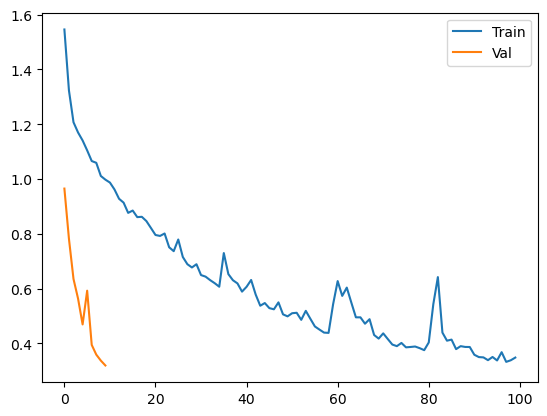

In [21]:
history_train, history_val = train_function(500)
history_train_list += history_train
history_val_list += history_val
plt.plot(history_train_list[1::5],label="Train")
plt.plot(history_val_list,label="Val")
plt.legend()
torch.save(model,f"TGAE2_GRUConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.model")

In [22]:
# history_train, history_val = train_function(50)
# history_train_list += history_train
# history_val_list += history_val
# plt.plot(history_train_list[1::5],label="Train")
# plt.plot(history_val_list,label="Val")
# plt.legend()

# Evaluation

In [23]:
batch_signal = BatchSignal(signals=signals_train, batch_size=BATCH_SIZE, seq_len=MIN_LEN).to(device)
batch_node_losses = test_loop(batch_signal, model, loss_f, optimizer, device, split_loss=True)
np.percentile(np.concatenate(batch_node_losses), 99.9) 

2.7100025467872673

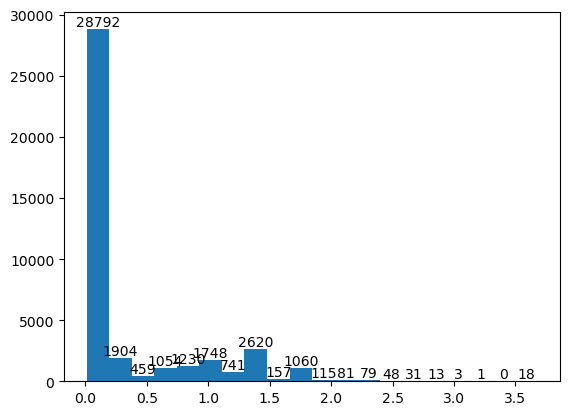

In [24]:
counts, edges, bars = plt.hist(np.concatenate(batch_node_losses),bins=20)
plt.bar_label(bars)
plt.show()

In [25]:
node_losses_list = []
for i_signal, signal in enumerate(signals_train):
    signal.to(device)
    node_losses = test_loop(signal, model, loss_f, optimizer, device, split_loss=True)
    node_losses_list.append(node_losses)

In [26]:
anomaly_threshold = np.percentile(np.concatenate([np.concatenate(node_losses) for node_losses in node_losses_list]), 99.95) 
print(anomaly_threshold)
tn, fp, fn, tp = 0, 0, 0, 0
for signal, node_losses in zip(signals_train,node_losses_list):
    _tn, _fp, _fn, _tp = signal_node_eval_func(signal, node_losses, anomaly_threshold)
    tn += _tn; fp += _fp; fn += _fn; tp += _tp
train_accuracy = (tn+tp)/(tn+fp+fn+tp)
train_precision = tp/(tp+fp)
train_recall = tp/(tp+fn)

print(train_accuracy, train_precision, train_recall)

3.4793181781768237
0.9950372208436724 0.8571428571428571 1.0


In [42]:
a = np.concatenate([np.concatenate(node_losses) for node_losses in node_losses_list])
print(np.mean(a),np.std(a))
(a-np.mean(a))/np.std(a)

0.35032684 0.52363724


array([ 2.1873672 ,  0.84675044,  0.6379867 , ..., -0.61859345,
       -0.5960119 , -0.6173175 ], dtype=float32)

In [27]:
anomaly_threshold = get_graph_anomaly_threshold(batch_signal, batch_node_losses,95)
train_accuracy, train_precision, train_recall = batch_graph_eval_func(batch_signal, batch_node_losses, anomaly_threshold)


In [28]:
snapshot_losses_list = []
for i_signal, signal in enumerate(signals_val):
    signal.to(device)
    snapshot_losses = test_loop(signal, model, loss_f, optimizer, device, split_loss=True)
    snapshot_losses_list.append(snapshot_losses)

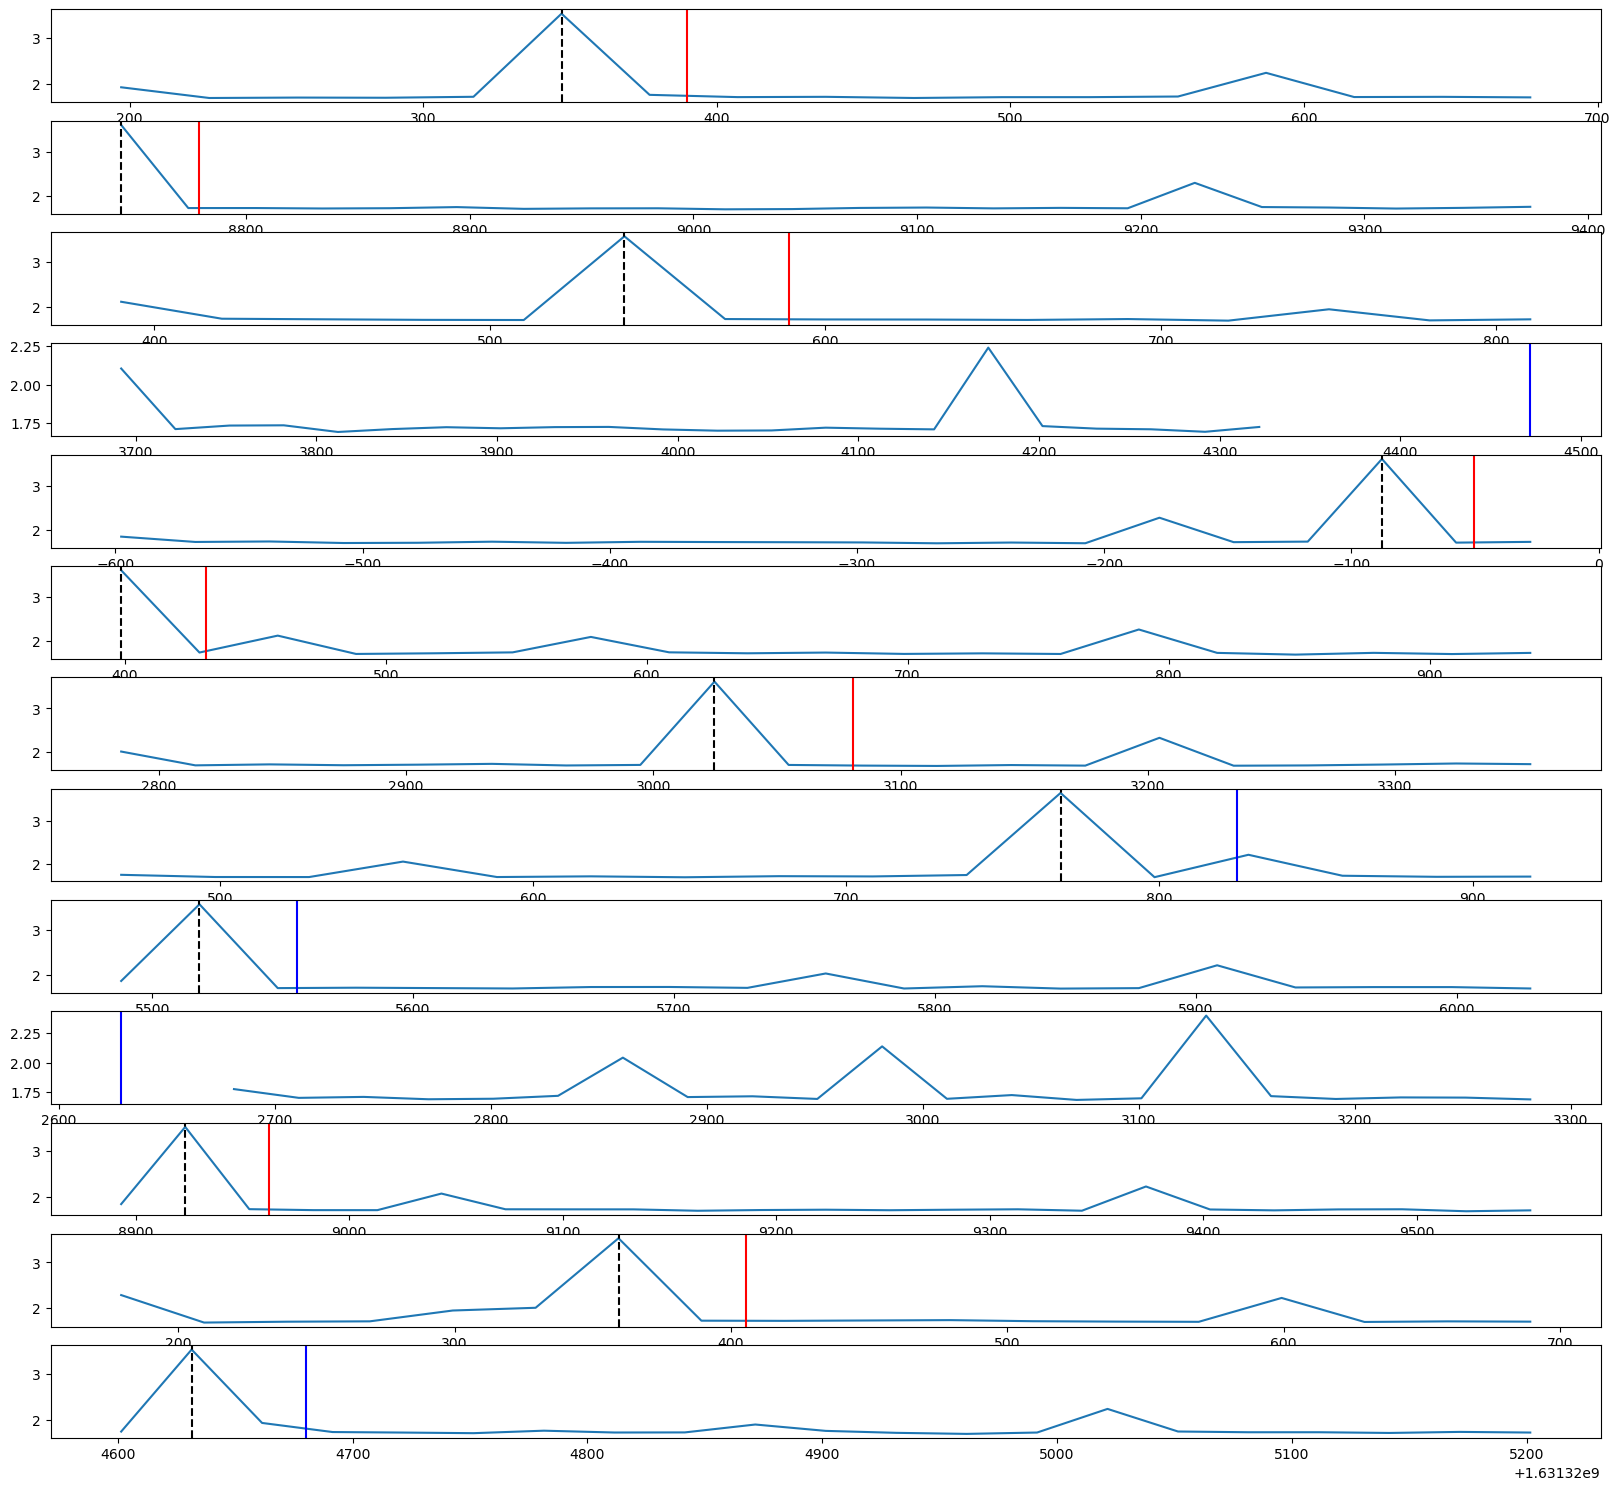

In [29]:
fig = plt.figure(figsize=(20,20))    
for i_signal,(signal, snapshot_losses, annotation) in enumerate(zip(signals_val, snapshot_losses_list, annotation_val)):
    ts_list = signal.ts_list
    plt.subplot(len(signals_val)+1,1,i_signal+1)
#     print(len(snapshot_losses))
    plt.plot(ts_list,[np.max(loss) for loss in snapshot_losses])
    for ts, label in zip(ts_list, signal.y):
        if label == 1:
            plt.axvline(x = ts, color = 'black', ls='--')
    if annotation[0] == 'dos':
        plt.axvline(x = float(annotation[1]), color = 'red', label = annotation[0])
    if annotation[0] == 'privesc':
        plt.axvline(x = float(annotation[1]), color = 'blue', label = annotation[0])

[(0, 87, 0), (1, 76, 0), (2, 69, 0), (3, 92, 0), (4, 80, 0), (5, 199, 1), (6, 71, 0), (7, 74, 0), (8, 73, 0), (9, 92, 0), (10, 67, 0), (11, 81, 0), (12, 75, 0), (13, 114, 0), (14, 69, 0), (15, 81, 0), (16, 73, 0)]


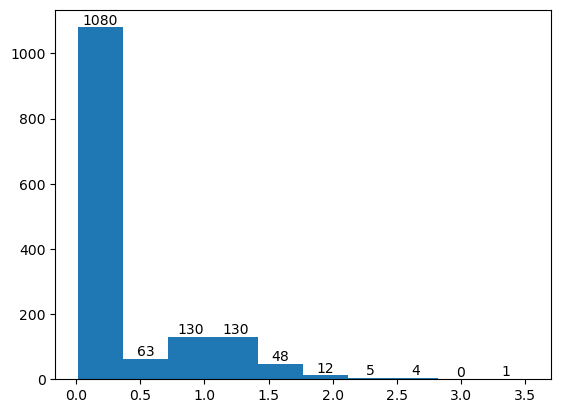

In [30]:
for signal, snapshot_losses in zip(signals_val, snapshot_losses_list):
#     print(snapshot_losses)
    print([(i_snapshot, len(loss),int(label)) for i_snapshot, (loss, label) in enumerate(zip(snapshot_losses, signal.y))])
    loss_list = []
    for losses in snapshot_losses:
        loss_list += list(losses)
    counts, edges, bars = plt.hist(loss_list)
    plt.bar_label(bars)
    plt.show()
    break
    

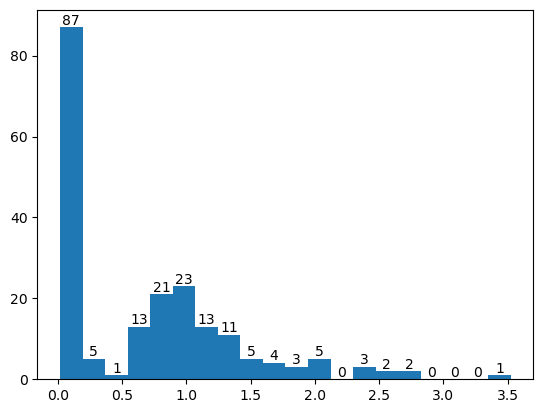

In [31]:
counts, edges, bars = plt.hist(snapshot_losses_list[0][5],bins=20)
plt.bar_label(bars)
plt.show()

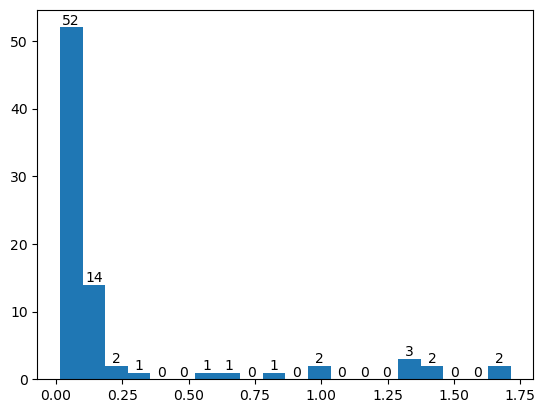

In [32]:
counts, edges, bars = plt.hist(snapshot_losses_list[0][11],bins=20)
plt.bar_label(bars)
plt.show()

In [33]:
# history_train, history_val = train_function(50)
# history_train_list += history_train
# history_val_list += history_val
# plt.plot(history_train_list[1::5],label="Train")
# plt.plot(history_val_list,label="Val")
# plt.legend()

In [34]:
# fig = plt.figure(figsize=(20,20))    
# for i_signal,(signal,y) in enumerate(zip(signals_val,y_val)):
#     snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
# #                 print(np.mean(val_loss))
# #     val_losses.append(np.mean(snapshot_losses))
#     ts_list = signal.ts_list
#     plt.subplot(len(signals_val)+1,1,i_signal+1)
# #     print(len(snapshot_losses))
#     plt.plot(ts_list,[np.max(loss) for loss in snapshot_losses])
#     if y[0] == 'dos':
#         plt.axvline(x = float(y[1]), color = 'red', label = y[0])
#     if y[0] == 'privesc':
#         plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
# # plt.show()
# plt.savefig(f'val_res_TGAE_NNConv_{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.png')

In [35]:
# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], use_cuda=True, record_shapes=True) as prof:
#         history_train, history_val = train_function(1)
#         history_train_list += history_train
#         history_val_list += history_val
#         plt.plot(history_train_list[1::5],label="Train")
#         plt.plot(history_val_list,label="Val")
#         plt.legend()
# print(prof.key_averages().table(sort_by="cuda_time_total"))

In [36]:
# print(prof.key_averages().table(sort_by="cpu_time_total"))

In [37]:
# fig = plt.figure(figsize=(20,20))    
# for i_signal,(signal,y) in enumerate(zip(signals_val,y_val)):
#     snapshot_losses = test_loop(signal, model, loss_f, optimizer, device)
# #                 print(np.mean(val_loss))
# #     val_losses.append(np.mean(snapshot_losses))
#     ts_list = signal.ts_list
#     plt.subplot(len(signals_val)+1,1,i_signal+1)
# #     print(len(snapshot_losses))
#     plt.plot(ts_list,snapshot_losses[:-1])
#     if y[0] == 'dos':
#         plt.axvline(x = float(y[1]), color = 'red', label = y[0])
#     if y[0] == 'privesc':
#         plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
# # plt.show()
# plt.savefig('val_res.png')

In [38]:
# torch.save(model,f"{GLOBAL_EPOCH}_{np.mean(history_train_list[-1]):.4f}_{np.mean(history_val_list[-1]):.4f}.model")

In [39]:
# history_train, history_val = train_function(100)
# history_train_list += history_train
# history_val_list += history_val
# plt.plot(history_train_list[1::5],label="Train")
# plt.plot(history_val_list,label="Val")
# plt.legend()

In [40]:
# states_encoder_val = []
# states_decoder_val = []
# for num_node in nums_node_val:
#     states_encoder_val.append(create_hidden_global(num_node=num_node,out_channels=model.gnn_out_channels))
#     states_decoder_val.append(create_hidden_global(num_node=num_node,out_channels=model.embedding_hidden_nums[-1]))    

# fig = plt.figure(figsize=(20,20))    
# for i_sample, (sample, y, hidden_encoder_global, hidden_decoder_global) in enumerate(zip(X_val, y_val, states_encoder_val, states_decoder_val)):
#     val_loss = test_loop(sample, hidden_encoder_global, hidden_decoder_global, model, loss_f, optimizer, device)
#     # print(np.mean(val_loss))
#     ts_list = [snapshot.timestamp for snapshot in sample]
#     plt.subplot(len(X_val)+1,1,i_sample+1)
#     plt.plot(ts_list,val_loss)
#     if y[0] == 'dos':
#         plt.axvline(x = float(y[1]), color = 'red', label = y[0])
#     if y[0] == 'privesc':
#         plt.axvline(x = float(y[1]), color = 'blue', label = y[0])
# plt.show()